In [107]:
import pandas as pd
import pymysql
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse

In [108]:
df = pd.read_csv(r'shedulers.csv', encoding='cp1251', sep=';')
df.head(10)

,ФИО,Расписание,Дата начала расписания,Дата окончания расписания
0,Поставщик 1,дддвсвнн,01.01.2019 0:00,10.01.2019 0:00
1,Поставщик 1,ннвннв,11.01.2019 0:00,15.01.2019 0:00
2,Поставщик 1,св,16.01.2019 0:00,20.01.2019 0:00
3,Поставщик 2,свсвсв,01.01.2019 0:00,07.01.2019 0:00
4,Поставщик 2,днвсв,08.01.2019 0:00,14.01.2019 0:00
5,Поставщик 2,ннддвсв,15.01.2019 0:00,31.12.9999 0:00
6,Поставщик 3,нвнвнв,01.01.2019 0:00,01.02.2019 0:00
7,Поставщик 3,двдвдвдв,02.02.2019 0:00,31.12.9999 0:00


Пример - есть расписания поставщиков заданное видом ДДННССВВ, где Д - дневная смена, Н - ночная смена, С - суточная смена, В - выходной

Считать что дневная смена с 08:00 по 20:00 Считать что ночная смена с 20:00 по 08:00 Считать что суточная смена с 08:00 по 08:00 завтрашнего дня

Описание работы расписания ДНСВ: 1 день - Д дневная смена 2 день - Н ночная смена 3 день - С суточная смена 4 день - В выходной день 5 день - Д дневная смена и т.д. циклично

# Задание 1

Создать таблицу (T_CONTRACTOR_SHERULER) под расписание и заполнить его с файла schedulers.csv. (Использовать любую библиотеку для заливки в СУБД (как вариант MS SQL)) Таблицу следует нормализовать.

- ID_NAME - идентификтор поставщика
- NAME - название поставщика
- SHEDULE - расписание
- DATE_BEGIN - дата начала действия расписания
- DATE_END - дата окончания действия расписания

Пример записи без нормализации:

- Поставщик 1 ДВС 01.01.2019 04.01.2019
- Поставщик 2 НВС 05.01.2019 31.12.2019

Вводные:

- Связку полей FIO, DATE_BEGIN считать уникальной.
- DATE_BEGIN не может привышать DATE_END.
- Можете продемонстрировать работу с ключами/ограничениями.

In [109]:
# согласно примеру записи приведем столбец к верхнему регистру
df['Расписание'] = df['Расписание'].apply(lambda x: x.upper())
df['Расписание'].head(2)

0    ДДДВСВНН
1      ННВННВ
Name: Расписание, dtype: object

### Для выполнения заданий выбрана библиотека MYSQL.
#### ФИО будет часто повторяться. Чтобы на этом сэкономить и иметь возможность управлять, разобьем таблицу и создадим подтаблицы T_CONTRACTOR_FIO и T_CONTRACTOR_DATA (прикладываю файл .sql)

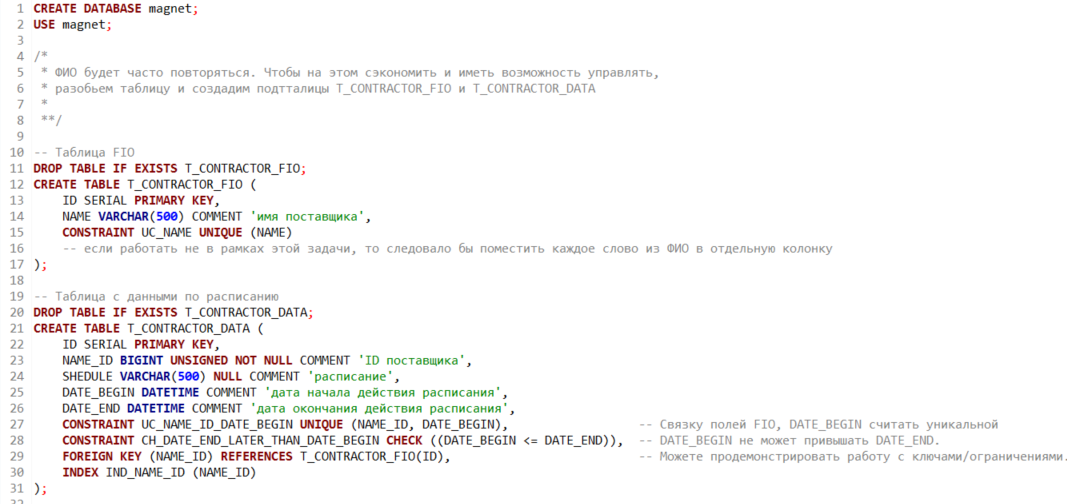

In [115]:
connection = pymysql.connect(
    host="localhost",
    user="root",
    port=3307,
    password="********", # deleted password
    database="magnet")

In [111]:
# Зполним таблиу T_CONTRACTOR_FIO
value = ''
for fio in df['ФИО'].unique():
    value= value + "('" + fio + "'),"
value = value[:-1]
sql = "INSERT IGNORE INTO `T_CONTRACTOR_FIO` (NAME) VALUES " + value + ';'

with connection.cursor() as cursor:
    cursor.execute(sql)
    connection.commit()

In [112]:
# получим ID T_CONTRACTOR_FIO
df_fio_id = pd.DataFrame()
sql = "SELECT * FROM `T_CONTRACTOR_FIO` WHERE `NAME` IN " + str(tuple(df['ФИО'].unique())) + ";"

with connection.cursor() as cursor:
    cursor.execute(sql)
    
for row in cursor:
    df_fio_id = df_fio_id.append({'ID': row[0], 'NAME': row[1]}, ignore_index=True)
df_fio_id['ID'] = df_fio_id['ID'].astype(int)
df_fio_id

,ID,NAME
0,1,Поставщик 1
1,2,Поставщик 2
2,3,Поставщик 3


In [113]:
# Вставим данные по расписанию (пакетно)
value = ''
for df_row in range(len(df)):
    value = (value 
             + "(" 
             + str(df_fio_id.loc[df_fio_id['NAME']==df['ФИО'][df_row],'ID'].values[0]) # ID 
             + ",'"
             + str(df['Расписание'][df_row])
             + "','"
             + str(datetime.strptime(df['Дата начала расписания'][df_row], "%d.%m.%Y %H:%M"))
             + "','"
             + str(datetime.strptime(df['Дата окончания расписания'][df_row], "%d.%m.%Y %H:%M"))
             + "'),")

value = value[:-1]
sql = "INSERT IGNORE INTO `T_CONTRACTOR_DATA` (NAME_ID,SHEDULE,DATE_BEGIN,DATE_END) VALUES " + value + ';'
    
with connection.cursor() as cursor:
    cursor.execute(sql)
    connection.commit()

In [114]:
connection.close()

#### Пример получившегося запроса:
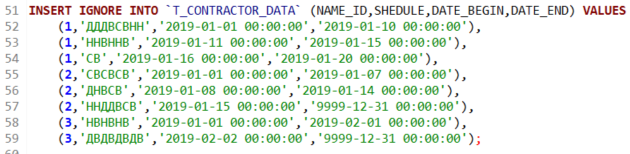
#### Результат запроса:
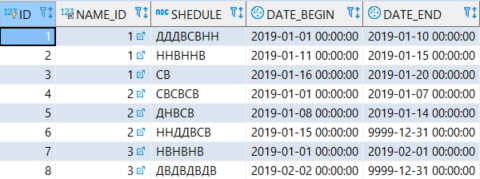

# Задание 2

Создать таблицу (T_CONTRACTOR_WORK_DAY) выходов на работу сотрудников.

Таблица должна иметь следующий вид

- ID - идентификатор записи
- NAME - название поставщика
- DATE_BEGIN - Начало рабочего дня (datetime)
- DATE_END - Конец рабочего дня (datetime)


Реализовал в sql:
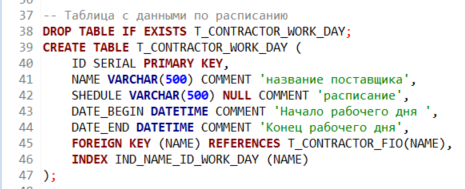

ER-Диаграмма:
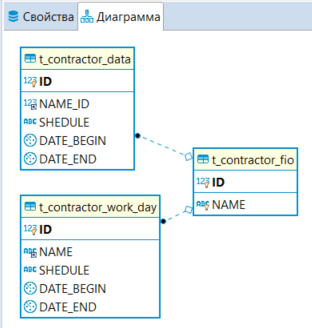

# Задание 3

Создать процедуру расчета рабочих дней.

Входящие параметры:

- Дата начала периода расчета
- Дата окончания периода расчета.

Ожидаемый результать выполнения хранимой процедуры - заполнение таблицы T_CONTRACTOR_WORK_DAY рабочими днями согласно расписания работы поставщиков из таблицы T_CONTRACTOR_SHERULER Выходные дни (В) не должны попадать в таблицу T_CONTRACTOR_WORK_DAY

Пример выполнения для Поставщика 1 (Из примера записи таблицы T_CONTRACTOR_SHERULER) с параметрами '01.01.2019' - '08.01.2019' таблица T_CONTRACTOR_WORK_DAY заполнится следующими данными:

- 1 Поставщик 1 01.01.2019 08:00 01.01.2019 20:00
- 2 Поставщик 1 03.01.2019 08:00 04.01.2019 08:00
- 3 Поставщик 1 04.01.2019 08:00 04.01.2019 08:00
- 4 Поставщик 1 05.01.2019 20:00 06.01.2019 08:00
- 5 Поставщик 1 07.01.2019 08:00 08.01.2019 08:00
- 6 Поставщик 1 08.01.2019 20:00 09.01.2019 08:00

Пояснение: для записей с 01.01.2019 по 04.01.2019 берется расписание ДВС

- 1 - Д - дневная смена далее следует выходной В - запись о выходном дне не попадает в таблицу
- 2 - С - суточная смена
- 3 - расписание закончилось, поэтому оно циклично начинается с начала (Д - дневная смена)
- 4 - С 05.01.2019 начинает действовать новое расписание - НВС берется Н - ночная смена далее следует выходной В - запись о выходном дне не попадает в таблицу
- 5 - С - суточная смена
- 6 - Снова Н - ночная смена

### Процедура реализована в файле .sql
### Результат работы процедуры с параметрами '01.01.2019' - '08.01.2019':
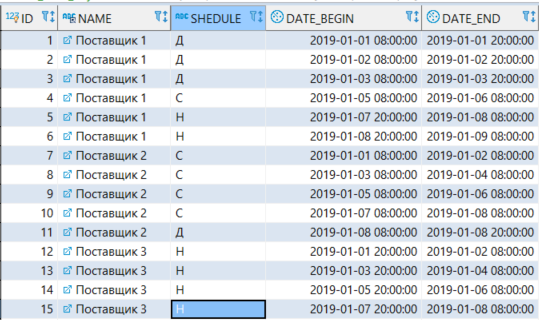

- Курсором перебиратся только те строки, которые имеют пересечение с вводимым интервалом
- Учтены случаи, когда начало вводимого интервала позже, чем в разбираемой строке
- Учтен повтор расписания и переход на новое расписание
- Вставка делается пакетно, не построчно, что гораздо быстрее
- При ошибке уникальности полей поставщика и даты начала смены выбрал вариант игнорирования ошибки
- В вышеприведнном примере в строке 3 ошибка (04.01.2019 08:00 04.01.2019 08:00) - временной интервал равен нулю

# Задание 4

С помощью SQL запросов:

- Сделать выборку содержащую сколько рабочих дней было у каждого поставщика
- Сделать выборку поставщиков, у которыйх было больше 10 рабочих дней за январь 2019 года
- Сделать выборку поставщиков, кто работал 14, 15 и 16 января 2019 года

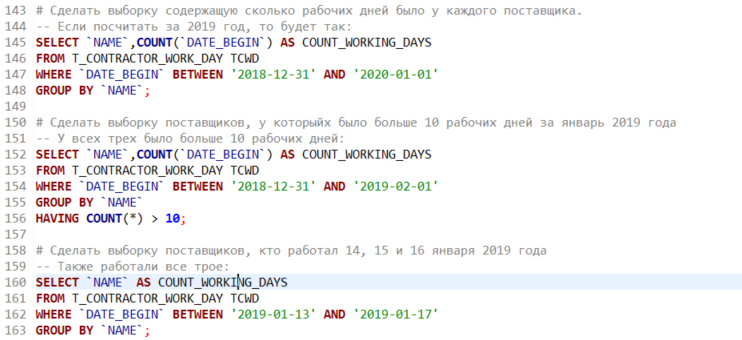

# Задание 5

Выполните задачи 3, 4 с помощью python.

### Задание 3 на python

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning) # целенаправлено отключить предупреждение 

In [116]:
def make_schedule(date_begin,date_end):
    """
    Процедура расчета рабочих дней
    """
    from pandas.core.common import SettingWithCopyWarning
    warnings.filterwarnings('ignore', category=SettingWithCopyWarning)
    
    df_copy = df.copy()
    # В pandas временные метки с использованием 64-разрядного целого числа представлены в интервале 1677-2262 годов
    # Поэтому работаем с интервалами через apply-lambda:
    df_new = df_copy.loc[
        ((df_copy['Дата начала расписания'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M") <= date_end)) &
        (df_copy['Дата окончания расписания'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M") >= date_begin)))
        ]

    # далее будем работать отдльно с днями и часами
    df_new['Дата начала расписания'] = df_new['Дата начала расписания'].apply(
                                                        lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M").date())
    df_new['Дата окончания расписания'] = df_new['Дата окончания расписания'].apply(
                                                        lambda x: datetime.strptime(x, "%d.%m.%Y %H:%M").date())
    date_begin = date_begin.date()
    date_end = date_end.date()
    req = ''

    for row in df_new.iterrows():
        fio = row[1]['ФИО']
        shed = row[1]['Расписание']
        d_beg = row[1]['Дата начала расписания']
        d_end = row[1]['Дата окончания расписания']

        shed = shed[(max((date_begin - d_beg).days,0))%len(shed):] #учтем случай, когда расп-е начин-ся не с 1-го дня
        d_beg = max(d_beg,date_begin) # скользящая дата для цикла
        count_ = 0 # счетчик для строки shed
        d_end_loop = min(d_end, date_end)
        print(fio,shed,d_beg,d_end_loop)

        while d_beg <= d_end_loop: # дата конца отчета с учетом заданного диапазона
            if count_ >= len(shed): # сброс счетчика, обеспечивает цикличность расписания
                count_ = 0
            sign = shed[count_] # определим букву Д-Н-С-В

            if sign == 'Д':
                beg_hour, end_hour = 8,20
            elif sign == 'Н':
                beg_hour, end_hour = 20,32
            elif sign == 'С':
                beg_hour, end_hour = 8,32
            else:
                d_beg = d_beg + timedelta(days=1)
                count_ += 1
                continue

            # собираем пакетный запрос на вставку (timedelta прибавит только целые дни, отображаем только часы)
            req = (req + '("' 
                   + fio + '","' 
                   + sign + '","' 
                   + str(d_beg+timedelta(hours=beg_hour)) + ' ' 
                   + str(timedelta(hours=(timedelta(hours=beg_hour).seconds//3600))) + '","' 
                   + str(d_beg+timedelta(hours=end_hour)) + ' ' 
                   + str(timedelta(hours=(timedelta(hours=end_hour).seconds//3600))) + '"),') 

            d_beg = d_beg + timedelta(days=1)
            count_ += 1

    # формируем итоговый текст запроса на пакетную вставку в таблицу
    req = req[:-1] # удалить лишнюю запятую в конце
    req = ('INSERT IGNORE INTO T_CONTRACTOR_WORK_DAY (NAME,SHEDULE,DATE_BEGIN,DATE_END) VALUES ' + req +';')
    
    return req
    
    
req = make_schedule(datetime.strptime("01.01.2019", "%d.%m.%Y"),
                       datetime.strptime("08.01.2019", "%d.%m.%Y"))
req.split('),(')

Поставщик 1 ДДДВСВНН 2019-01-01 2019-01-08
Поставщик 2 СВСВСВ 2019-01-01 2019-01-07
Поставщик 2 ДНВСВ 2019-01-08 2019-01-08
Поставщик 3 НВНВНВ 2019-01-01 2019-01-08


['INSERT IGNORE INTO T_CONTRACTOR_WORK_DAY (NAME,SHEDULE,DATE_BEGIN,DATE_END) VALUES ("Поставщик 1","Д","2019-01-01 8:00:00","2019-01-01 20:00:00"',
 '"Поставщик 1","Д","2019-01-02 8:00:00","2019-01-02 20:00:00"',
 '"Поставщик 1","Д","2019-01-03 8:00:00","2019-01-03 20:00:00"',
 '"Поставщик 1","С","2019-01-05 8:00:00","2019-01-06 8:00:00"',
 '"Поставщик 1","Н","2019-01-07 20:00:00","2019-01-08 8:00:00"',
 '"Поставщик 1","Н","2019-01-08 20:00:00","2019-01-09 8:00:00"',
 '"Поставщик 2","С","2019-01-01 8:00:00","2019-01-02 8:00:00"',
 '"Поставщик 2","С","2019-01-03 8:00:00","2019-01-04 8:00:00"',
 '"Поставщик 2","С","2019-01-05 8:00:00","2019-01-06 8:00:00"',
 '"Поставщик 2","С","2019-01-07 8:00:00","2019-01-08 8:00:00"',
 '"Поставщик 2","Д","2019-01-08 8:00:00","2019-01-08 20:00:00"',
 '"Поставщик 3","Н","2019-01-01 20:00:00","2019-01-02 8:00:00"',
 '"Поставщик 3","Н","2019-01-03 20:00:00","2019-01-04 8:00:00"',
 '"Поставщик 3","Н","2019-01-05 20:00:00","2019-01-06 8:00:00"',
 '"Поставщи

In [106]:
def insert_schedule(req):
    """
    Процедура вставки информации в базу данных
    """
    connection = pymysql.connect(
    host="localhost",
    user="root",
    port=3307,
    password="********",
    database="magnet")

    # Зполним таблиу T_CONTRACTOR_WORK_DAY
    with connection.cursor() as cursor:
        cursor.execute(req)
        connection.commit()

    connection.close()
    
    
insert_schedule(req)

### Результат работы процедур с параметрами '01.01.2019' - '08.01.2019':
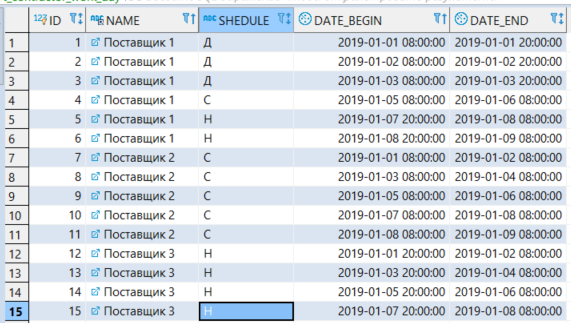

### Можно сформировать расписание далее 2262 года:
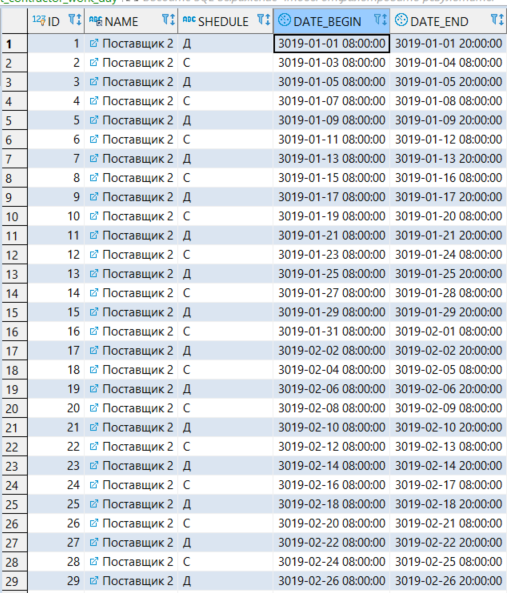

### Задание 4 на python

In [100]:
connection = pymysql.connect(
    host="localhost",
    user="root",
    port=3307,
    password="********",
    database="magnet")

In [96]:
# Сделать выборку содержащую сколько рабочих дней было у каждого поставщика (также, как в sql за 2019 год)
df_req = pd.DataFrame()
sql = "SELECT `NAME`, COUNT(`DATE_BEGIN`) AS COUNT_WORKING_DAYS \
FROM T_CONTRACTOR_WORK_DAY TCWD \
WHERE `DATE_BEGIN` BETWEEN '2018-12-31' AND '2020-01-01' \
GROUP BY `NAME`;"

with connection.cursor() as cursor:
    cursor.execute(sql)

# rows = cursor.fetchall()
colls = [x[0] for x in cursor.description]
for row in cursor:
    df_req = df_req.append({'1': row[0], 
                            '2': row[1]}, ignore_index=True)
df_req.columns = colls
df_req

,NAME,COUNT_WORKING_DAYS
0,Поставщик 1,15.0
1,Поставщик 2,260.0
2,Поставщик 3,183.0


In [97]:
# Сделать выборку поставщиков, у которыйх было больше 10 рабочих дней за январь 2019 года 
df_req = pd.DataFrame()
sql = "SELECT `NAME`,COUNT(`DATE_BEGIN`) AS COUNT_WORKING_DAYS \
FROM T_CONTRACTOR_WORK_DAY TCWD \
WHERE `DATE_BEGIN` BETWEEN '2018-12-31' AND '2019-02-01' \
GROUP BY `NAME` \
HAVING COUNT(*) > 10;"

with connection.cursor() as cursor:
    cursor.execute(sql)

# rows = cursor.fetchall()
colls = [x[0] for x in cursor.description]
for row in cursor:
    df_req = df_req.append({'1':row[0], 
                            '2': row[1]}, ignore_index=True)
df_req.columns = colls
df_req

,NAME,COUNT_WORKING_DAYS
0,Поставщик 1,15.0
1,Поставщик 2,22.0
2,Поставщик 3,16.0


In [98]:
# Сделать выборку поставщиков, кто работал 14, 15 и 16 января 2019 года
df_req = pd.DataFrame()
sql = "SELECT `NAME` AS COUNT_WORKING_DAYS \
FROM T_CONTRACTOR_WORK_DAY TCWD \
WHERE `DATE_BEGIN` BETWEEN '2019-01-13' AND '2019-01-17' \
GROUP BY `NAME`;"

with connection.cursor() as cursor:
    cursor.execute(sql)

# rows = cursor.fetchall()
colls = [x[0] for x in cursor.description]
for row in cursor:
    df_req = df_req.append({'1':row[0]}, ignore_index=True)
df_req.columns = colls
df_req

,COUNT_WORKING_DAYS
0,Поставщик 1
1,Поставщик 2
2,Поставщик 3


In [102]:
connection.close()

# Формат ответа:

- Необходимо вернуть .ipynb с кодом заливки данных и скрипты .sql для создания всех объектов и выполнения всех запросов. Также можно приложить ссылку на github.
- Выполнение заданий будет оцениваться с точки зрения лаконичности/элегантности кода и глубины Вашего знания sql.